<a href="https://colab.research.google.com/github/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/Prototype_Santander_BEDU_jalisco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototype Introducción

Nuestro proyecto se basa en la utilización de diferentes métodos de clasificación de imágenes de satélite, verificando que método es el más optimo de acuerdo al tiempo de computo y su precision, en una arena de clasificadores. 

La libreta contiene principalmente datos de estado de Jalisco, se descargaron las imgágenes de satélite del [siguiente repositorio](https://earthexplorer.usgs.gov/).

En este caso, las imágenes del satélite Landsat 8 en valores de reflectancia del terreno,con resolución de 30 metros y crrespondientes parte de la zona metropolitana de Guadalajara y areas aledañas, en el estado de Jalisco, México. La siguiente tabla presenta una descripcion general de los datos.


| | |
| --- | --- |
| Satélite | Landsat 8 |
| Fecha de adquisición | 20-03-2018 |
| Height | 1328  |
| Width | 643   |
| # de Bandas | 7 |
| Resolucion espacial | 30 metros | 


Para iniciar nuestra libreta vamos a llamar las primeras librerias de python, las cuales las usaremos para cargar nuestros datos, visualizar las imágenes, etc.

Es importante instalar **rasterio** para poder accesar y trabajar con los datos son complicaciones.



In [ ]:
!pip install rasterio

In [ ]:
# Importar pandas para dataframes
import pandas as pd

# Importar librerias numericas
import numpy as np

# Importar las dependencias usadas para el uso de imagenes de satélite 
import rasterio as rio

# Importar las librerias de graficacion
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rasterio.plot import show


In [ ]:
# Importamos los datos desde github
Landsat_data = []
for i in range(1,8):
    Landsat_data.append(f"https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B{i}.tif?raw=true")


# Acomodamos los datos en orden de las bandas
Landsat_data.sort()

# Visualizamos el path de los archivos
Landsat_data

['https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B1.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B2.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B3.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B4.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B5.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B6.tif?raw=true',
 'https://github.com/zoegarm/Clasificacion-de-imagenes-de-satelite/blob/main/images_sat/jalisco_B7.tif?raw=true']

In [ ]:
# Realizamos un array con las 7 imágenes

imagenes = []
labels = []
for i in range(0,len(Landsat_data)):
  print(f"La banda {Landsat_data[i][-15:-13]}, esta almacenado en la posicion {[i]} del array")
  labels.append(Landsat_data[i][-6:-4])
  with rio.open(Landsat_data[i], 'r') as d:
    imagenes.append(d.read(1))

arr_img = np.stack(imagenes)
arr_img = np.moveaxis(arr_img, 0, -1)

# Ahora vamos a verificar el arreglo de nuestro array

print(f"La dimension de nuestro array es:\n {arr_img.shape[2]} bandas (o canales)\n {arr_img.shape[0]} alto\n {arr_img.shape[1]} ancho")

La banda B1, esta almacenado en la posicion [0] del array
La banda B2, esta almacenado en la posicion [1] del array
La banda B3, esta almacenado en la posicion [2] del array
La banda B4, esta almacenado en la posicion [3] del array
La banda B5, esta almacenado en la posicion [4] del array
La banda B6, esta almacenado en la posicion [5] del array
La banda B7, esta almacenado en la posicion [6] del array
La dimension de nuestro array es:
 7 bandas (o canales)
 1328 alto
 643 ancho


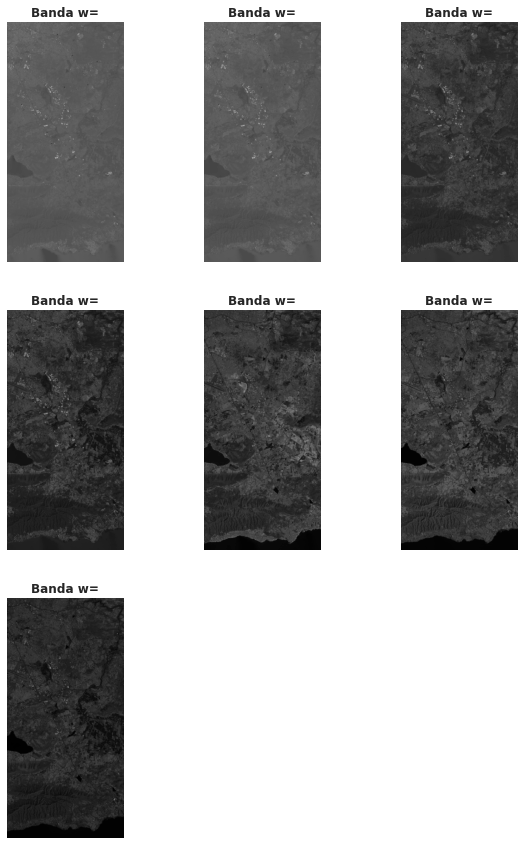

In [ ]:
# Vamos a mostrar las imagenes de satélite por cada banda
sns.set(style="white")
fig = plt.figure(figsize=(10, 15))
for i in range(1, len(labels) + 1 ):
    ax = fig.add_subplot(3, 3, i)
    show(arr_img[:,:,i-1], cmap='Greys_r', ax=ax, title=f"Banda {labels[i-1]}")
    plt.axis('off')

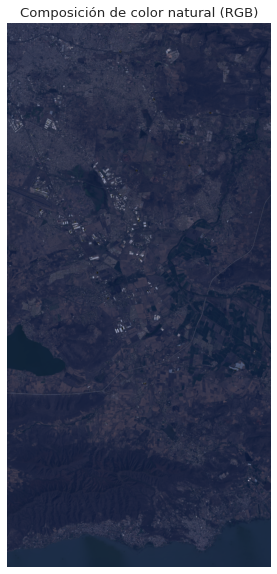

In [ ]:
# Ahora veamos como obtener una imagen de color natural con las bandas RGB

# Normaliza las bandas en escala de 0.0 - 1.0
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Seleccionamos los array que corresponde a cada banda 
red = arr_img[:,:,3]
green = arr_img[:,:,2]
blue = arr_img[:,:,1]

# Normalizamos con la funcion 
red_norm = normalize(red)
green_norm = normalize(green)
blue_norm = normalize(blue)

# Realizamos el Stack
rgb = np.dstack((red_norm, green_norm, blue_norm))

# Vemos la composicion de color
fig = plt.figure(figsize=(5, 10))
plt.imshow(rgb)
plt.title("Composición de color natural (RGB)")
plt.axis('off');

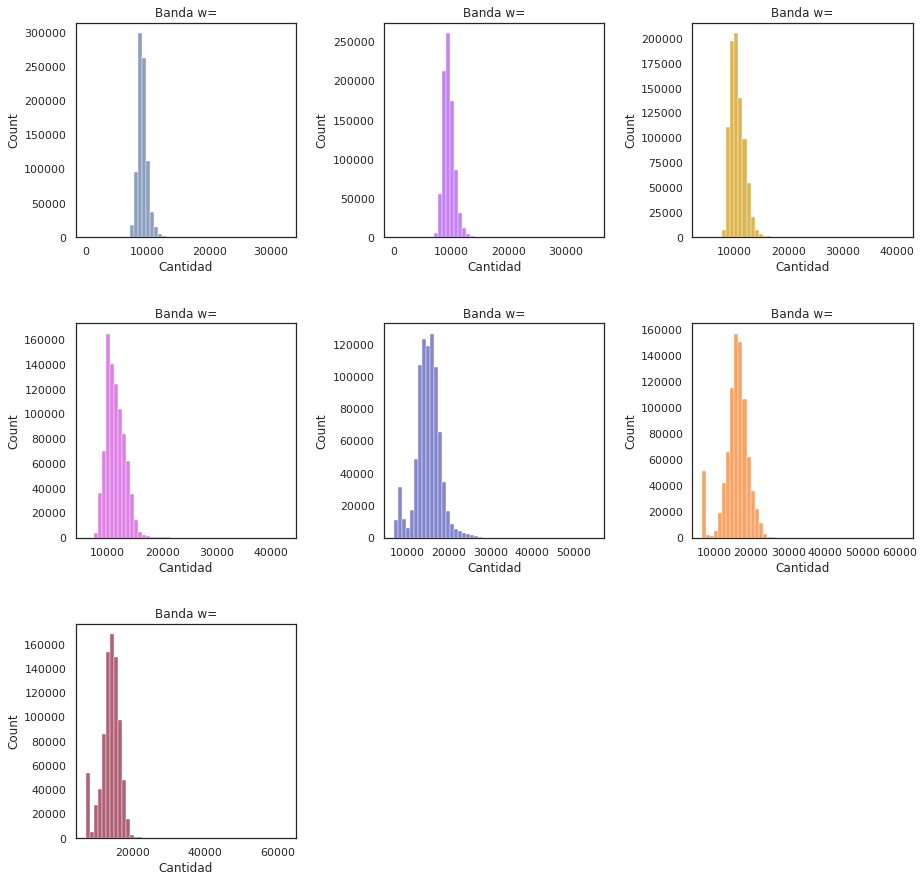

In [ ]:
# Ahora analizaremos los histogramas.

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1, len(labels) + 1): #
    ax = fig.add_subplot(3, 3, i)
    sns.histplot(arr_img[:,:,i-1].flatten(),
                 color=np.random.rand(3,), bins = 50)
    ax.set_title(f"Banda {labels[i-1]}")
    ax.set(xlabel="Cantidad")

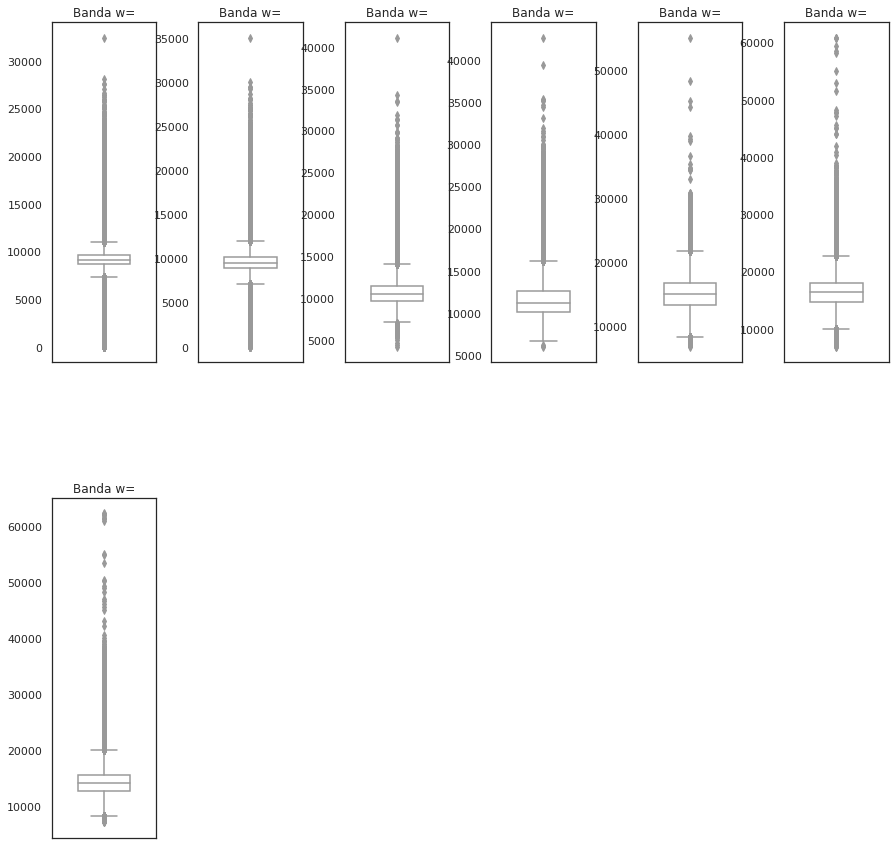

In [ ]:
# Veamos los bloxplots

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1, len(labels) + 1 ):
    ax = fig.add_subplot(2, 6, i)
    sns.boxplot(y=arr_img[:,:,i-1].flatten(),
                color='white', width=.5)
    ax.set_title(f"Banda {labels[i-1]}")

plt.show()

# Clasificación no supervisada: K Means Clustering y reduccion usando PCA

Para este apartado no usaremos los dataset de entrenamiento y prueba, veremos los resultados que obtenemos a partir de una clasificación no supervisada.

Usaremos el analisis de componentes principales, así como el método del inercia para poder encontrar el número de 

In [ ]:
%%time

from sklearn.decomposition import PCA

# analisis de componentes principales, usando los datos previamente preprocesados
pca = PCA(n_components = 6)

pca.fit(X_estan)

data_pca = pca.transform(X_estan)

print("La varianza explicada en cada componente principal es:")
for i in range(0, len(pca.explained_variance_ratio_)):
    print(f"PCA{i+1} = {pca.explained_variance_ratio_[i]}")
print(f"El total de la varianza dentro de las componentes es:\n {np.sum(pca.explained_variance_ratio_)}")

La varianza explicada en cada componente principal es:
PCA1 = 0.7516032502938785
PCA2 = 0.15634839507842674
PCA3 = 0.06986837797460513
PCA4 = 0.01543344511076625
PCA5 = 0.0036784915044556048
PCA6 = 0.0019617267815460336
El total de la varianza dentro de las componentes es:
 0.9988936867436784
CPU times: user 456 ms, sys: 265 ms, total: 720 ms
Wall time: 574 ms


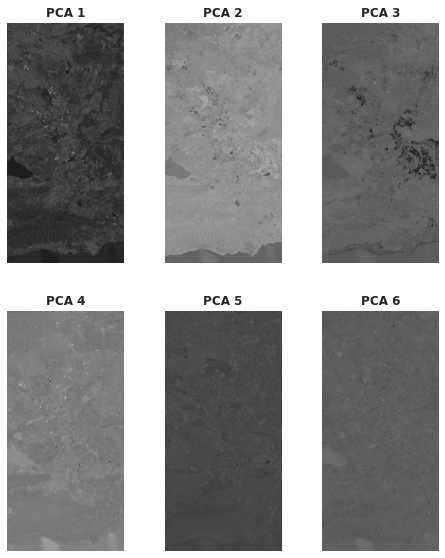

In [ ]:
# Vamos a hacer un plot de nuestras PCA
# Primero realizaremos un reshape para regresarlos a la misma 
# forma que los datos originales, y que tengan la misma dimensiones

data_pca_reshape = data_pca.reshape((1328, 643, data_pca.shape[1]))

# Loop para visualizar nuestras componentes
fig = plt.figure(figsize=(8, 15))
for i in range(1, 6+ 1 ):
    ax = fig.add_subplot(3, 3, i)
    show(data_pca_reshape[:,:,i-1], cmap='Greys_r', ax=ax, title=f"PCA {i}")
    plt.axis('off')

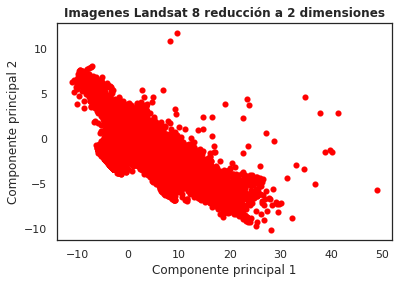

In [ ]:
# ahora graficaremos nuestras dos primeras componentes 

plt.scatter(x=data_pca_reshape[:,:,0], y=data_pca_reshape[:,:,1], color='red',lw=0.1)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Imagenes Landsat 8 reducción a 2 dimensiones',fontweight='bold')
plt.show()

In [ ]:
# Inercia
import sklearn.cluster as cluster
from tqdm import tqdm

inertia = []
for i in tqdm(range(2,12)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=50)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)

100%|██████████| 10/10 [09:46<00:00, 58.68s/it]


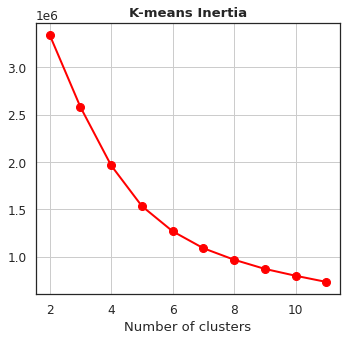

In [ ]:
# Finalmente realizamos el plot
sns.set(style='white',font_scale=1.1, rc={'figure.figsize':(12,5)})

plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='o',lw=2,ms=8,color='red')
plt.xlabel('Number of clusters')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

A partir de la gráfica anterior nos dice que debemos realzar la clasificacion en 6 clasificaciones. A continuación usaremos el método de k-means para realizar la clasificación.  

Es importante mencionar que esta clasificación sera usada como los "reales del terreno", es decir **y_data** para poder analizar los algoritmos de Machine learning, y así, ver su precisión.

In [ ]:
%%time
# Ahora vamos a realizar nuestra clasificacion

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=25, init="k-means++")

kmeans.fit(data_pca)

clasificacion = kmeans.predict(data_pca)

CPU times: user 27.5 s, sys: 2.56 s, total: 30 s
Wall time: 26.9 s


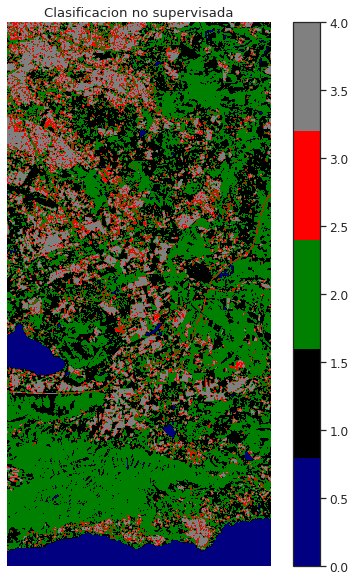

In [ ]:
# Veamos nuestros resultados

class_color = ListedColormap(['navy', 'black', 'green', 'red', "grey"])

plt.figure(figsize=(8, 10))
plt.imshow(clasificacion.reshape(1328, 643), cmap=class_color)
plt.title("Clasificacion no supervisada")
plt.colorbar()
plt.axis('off');

In [ ]:
# Ahora usaremos esta clasificacion como y_data

y_data = clasificacion

# Separación, validación y evaluación para algoritmos de ML

Dentro de este apartado realizaremos una estandarizacion de los datos moviendo la media a 0 y la desviacion estandar a la unidad.

Después de este proceso procederemos a realizar la separación en entrenamiento y prueba para clasificar nuestras imágenes...

In [ ]:
# Cargamos nuestra libreria
from sklearn.preprocessing import StandardScaler

# Hacemos un reshape para dividir todos los datos de forma lineal, en cada una de las bandas
X_data = arr_img.reshape(-1, 7)

# Realizamos la estandarizacion
scaler = StandardScaler().fit(X_data)
X_estan = scaler.transform(X_data)
print(f"La nueva dimensión del array es {X_estan.shape}")
1328 * 643


La nueva dimensión del array es (853904, 7)


853904

In [ ]:
# Ahora a dividir nuestro array con las imágenes 
from sklearn.model_selection import train_test_split

# Es importante usar el .ravel() pues de esta forma nuestro array tendra las 
# mismas dimensiones al array con las 12 imagenes de satélite
X_train, X_test, y_train, y_test = train_test_split(X_estan, y_data.ravel(), 
                                  test_size=0.30, stratify = y_data.ravel(), random_state=50)
print(f'Dimensiones X_train: {X_train.shape}\nDimension X_test: {X_test.shape}\nDimension y_train: {y_train.shape}\nDimension y_test:{y_test.shape}')

Dimensiones X_train: (597732, 7)
Dimension X_test: (256172, 7)
Dimension y_train: (597732,)
Dimension y_test:(256172,)


# Clasificacion supervisada: K-Nearest Neighbor Classifier (K-NNC)

In [ ]:
%%time

# Importamos la libreria
from sklearn.neighbors import KNeighborsClassifier

# Hacemos el modelo con 6 clusters, que son los valores clasificados del terreno
knn = KNeighborsClassifier(n_neighbors=6)

# Obtenemos el fit entre los datos de entrenamiento
knn.fit(X_train, y_train)

# Hacemos predicciones
knn_pred = knn.predict(X_test)

CPU times: user 37.3 s, sys: 102 ms, total: 37.4 s
Wall time: 37.2 s


In [ ]:
# Calculamos la precisión
from sklearn.metrics import classification_report, accuracy_score

print(f"Precisión: {accuracy_score(y_test, knn_pred)*100}")

# Realizamos el reporte de clasificacion
print(classification_report(y_test, knn_pred))

Precisión: 99.25635900879098
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.99      1.00      0.99     92138
           2       1.00      0.99      0.99     91426
           3       0.98      0.99      0.98      1632
           4       1.00      0.99      0.99     53182

    accuracy                           0.99    256172
   macro avg       0.99      0.99      0.99    256172
weighted avg       0.99      0.99      0.99    256172



CPU times: user 1min 38s, sys: 229 ms, total: 1min 38s
Wall time: 1min 37s


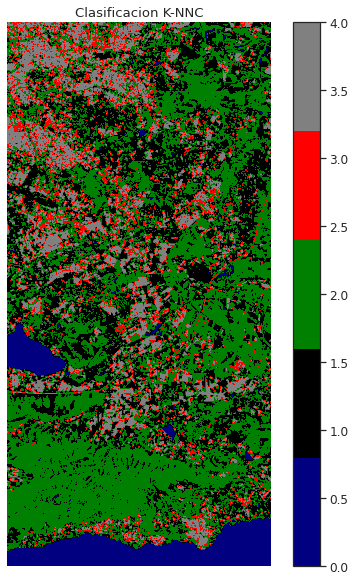

In [ ]:
%%time

# Vamos a ver nuestros resultados

plt.figure(figsize=(8, 10))
plt.imshow(knn.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificacion K-NNC")
plt.colorbar()
plt.axis('off');

# Arboles de decision: Decision tree

Ahora usaremos arboles de decisión para observar como nuestra clasificación puede variar o no de los datos del terreno. De igual forma analizar el tiempo de computo requerido para esta clasificacion.

In [ ]:
%%time

# Importamos la libreria
from sklearn.tree import DecisionTreeClassifier

# Agregamos el modelo
dtc = DecisionTreeClassifier()

# Realizamos nuestra clasificacion usando los datos de entrenamiento
dtc = dtc.fit(X_train, y_train)

# Prediccion en los datos de prueba
dtc_pred = dtc.predict(X_test)

CPU times: user 9.29 s, sys: 17.5 ms, total: 9.31 s
Wall time: 9.31 s


In [ ]:
# Calculamos la precisión
print(f"Precisión: {accuracy_score(y_test, dtc_pred)*100}")

# Realizamos el reporte de clasificacion
print(classification_report(y_test, dtc_pred))

Precisión: 98.16568555501772
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.98      0.98      0.98     92138
           2       0.99      0.99      0.99     91426
           3       0.97      0.97      0.97      1632
           4       0.98      0.98      0.98     53182

    accuracy                           0.98    256172
   macro avg       0.98      0.98      0.98    256172
weighted avg       0.98      0.98      0.98    256172



CPU times: user 160 ms, sys: 975 µs, total: 161 ms
Wall time: 164 ms


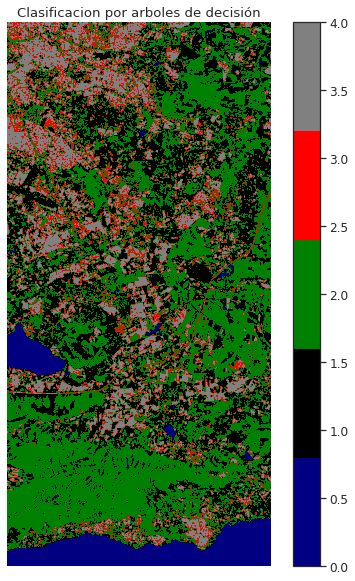

In [ ]:
%%time

# Vamos a ver nuestros resultados, y la clasificacion de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(dtc.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificacion por arboles de decisión")
plt.colorbar()
plt.axis('off');

# Arboles de decision: Random Forest

De manera similar, ahora usaremos el random forest para analizar nuestra clasificación.

In [ ]:
%%time

# Importamos la libreria
from sklearn.ensemble import RandomForestClassifier

# Agregamos el modelo
rfc = RandomForestClassifier()

# Realizamos nuestra clasificacion usando los datos de entrenamiento
rfc = rfc.fit(X_train, y_train)

# Prediccion en los datos de prueba
rfc_pred = rfc.predict(X_test)

CPU times: user 3min 22s, sys: 331 ms, total: 3min 23s
Wall time: 3min 22s


In [ ]:
# Calculamos la precisión
print(f"Precisión: {accuracy_score(y_test, rfc_pred)*100}")

# Realizamos el reporte de clasificacion
print(classification_report(y_test, rfc_pred))

Precisión: 99.29227237949503
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.99      0.99      0.99     92138
           2       0.99      0.99      0.99     91426
           3       0.99      0.98      0.99      1632
           4       0.99      0.99      0.99     53182

    accuracy                           0.99    256172
   macro avg       0.99      0.99      0.99    256172
weighted avg       0.99      0.99      0.99    256172



CPU times: user 12.9 s, sys: 129 ms, total: 13 s
Wall time: 12.9 s


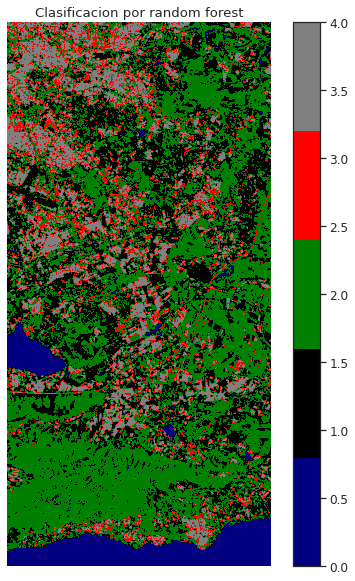

In [ ]:
%%time

# Vamos a ver nuestros resultados, y la clasificacion de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(rfc.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificacion por random forest")
plt.colorbar()
plt.axis('off');

# Arboles de decision: Decision tree regression

In [ ]:
%%time
# importamos el decision tree regresion
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

# Realizamos nuestra clasificacion usando los datos de entrenamiento
dtr = dtr.fit(X_train, y_train)

# Prediccion en los datos de prueba
dtr_pred = dtr.predict(X_test)

CPU times: user 9.5 s, sys: 8.16 ms, total: 9.51 s
Wall time: 9.47 s


In [ ]:
# Calculamos la precisión
print(f"Precisión: {accuracy_score(y_test, dtr_pred)*100}")

# Realizamos el reporte de clasificacion
print(classification_report(y_test, dtr_pred))

Precisión: 98.19418203394594
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.98      0.98      0.98     92138
           2       0.99      0.99      0.99     91426
           3       0.97      0.97      0.97      1632
           4       0.98      0.98      0.98     53182

    accuracy                           0.98    256172
   macro avg       0.98      0.98      0.98    256172
weighted avg       0.98      0.98      0.98    256172



CPU times: user 140 ms, sys: 166 µs, total: 140 ms
Wall time: 145 ms


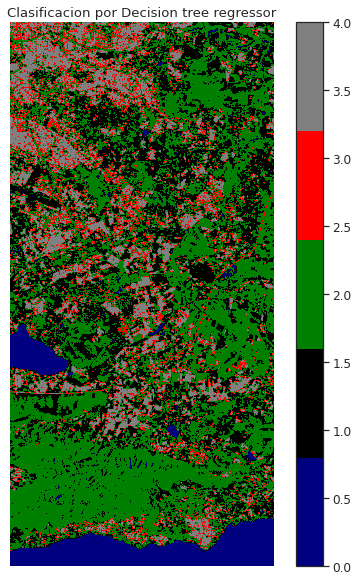

In [ ]:
%%time

# Vamos a ver nuestros resultados, y la clasificacion de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(dtr.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificacion por Decision tree regressor")
plt.colorbar()
plt.axis('off');

# Arboles de decision: Decision tree regression con AdaBoost

Este algoritmo funciona de la misma forma que el anterior, con la diferencia de que tiene diferentes estimadores, es decir, usa usa mas arboles de decision (boosts) para que la regresion se ajuste con mayor detalle.

In [ ]:
%%time
# importamos AdaBoost
from sklearn.ensemble import AdaBoostRegressor

# Usaremos un modelo con 200 arboles de decision
adtr = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=50, random_state=25)

# Realizamos nuestra clasificacion usando los datos de entrenamiento
adtr = adtr.fit(X_train, y_train)

# Prediccion en los datos de prueba
adtr_pred = adtr.predict(X_test)


CPU times: user 3min 17s, sys: 520 ms, total: 3min 18s
Wall time: 3min 17s


In [ ]:
# Calculamos la precisión
print(f"Precisión: {accuracy_score(y_test, adtr_pred)*100}")

# Realizamos el reporte de clasificacion
print(classification_report(y_test, adtr_pred))

Precisión: 99.36683165997844
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17794
           1       0.99      0.99      0.99     92138
           2       1.00      1.00      1.00     91426
           3       0.99      0.98      0.99      1632
           4       0.99      0.99      0.99     53182

    accuracy                           0.99    256172
   macro avg       0.99      0.99      0.99    256172
weighted avg       0.99      0.99      0.99    256172



CPU times: user 5.87 s, sys: 506 ms, total: 6.38 s
Wall time: 6.34 s


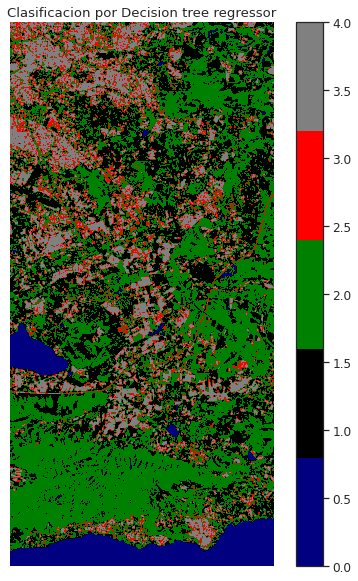

In [ ]:
%%time

# Vamos a ver nuestros resultados, y la clasificacion de todos los datos

plt.figure(figsize=(8, 10))
plt.imshow(adtr.predict(X_estan).reshape((1328, 643)), cmap=class_color) #
plt.title("Clasificacion por Decision tree regressor")
plt.colorbar()
plt.axis('off');

# Redes Neuronales

# Arena de clasificacidores:



In [ ]:
# from sklearn.metrics import mean_absolute_error